# Import the necesary libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import pmdarima as pmd
from statsmodels.tsa.arima.model import ARIMA

# Helper Functions



In [2]:
def plot_timeseries(xV, get_histogram=False, title='', savepath=''):
    # #plot timeseries
    fig, ax = plt.subplots(1, 1, figsize=(14, 8))
    ax.plot(xV, marker='x', linestyle='--', linewidth=2);
    ax.set_xlabel('time')
    ax.set_ylabel('value')
    if len(title) > 0:
        ax.set_title(title, x=0.5, y=1.0);
    plt.tight_layout()
    if len(savepath) > 0:
        plt.savefig(f'{savepath}/{title}_xM.jpeg')
    # #plot histogram
    if get_histogram:
        fig, ax = plt.subplots(1, 1, figsize=(14, 8))
        ax.hist(xV, alpha=0.8, rwidth=0.9);
        ax.set_xlabel('value')
        ax.set_title('Histogram')
        plt.tight_layout()
        if len(title) > 0:
            ax.set_title(title, x=0.5, y=1.0);
        plt.tight_layout()
        if len(savepath) > 0:
            plt.savefig(f'{savepath}/{title}_hist.jpeg')

def seasonal_components(xV, period):
    '''
    computes the periodic time series comprised of repetetive
    patterns of seasonal components given a time series and the season
    (period).
    '''
    n = xV.shape[0]
    sV = np.full(shape=(n,), fill_value=np.nan)
    monV = np.full(shape=(period,), fill_value=np.nan)
    for i in np.arange(period):
        monV[i] = np.mean(xV[i:n:period])
    monV = monV - np.mean(monV)
    for i in np.arange(period):
        sV[i:n:period] = monV[i] * np.ones(shape=len(np.arange(i, n, period)))
    return sV

def get_acf(xV, lags=10, alpha=0.05, show=True):
    '''
    calculate acf of timeseries xV to lag (lags) and show
    figure with confidence interval with (alpha)
    '''
    acfV = acf(xV, nlags=lags)[1:]
    z_inv = norm.ppf(1 - alpha / 2)
    upperbound95 = z_inv / np.sqrt(xV.shape[0])
    lowerbound95 = -upperbound95
    if show:
        fig, ax = plt.subplots(1, 1, figsize=(14, 8))
        ax.plot(np.arange(1, lags + 1), acfV, marker='o')
        ax.axhline(upperbound95, linestyle='--', color='red', label=f'Conf. Int {(1 - alpha) * 100}%')
        ax.axhline(lowerbound95, linestyle='--', color='red')
        ax.set_title('ACF')
        ax.set_xlabel('Lag')
        ax.set_xticks(np.arange(1, lags + 1))
        ax.grid(linestyle='--', linewidth=0.5, alpha=0.15)
        ax.legend()
    return acfV


def get_pacf(xV, lags=10, alpha=0.05, show=True):
    '''
    calculate pacf of timeseries xV to lag (lags) and show
    figure with confidence interval with (alpha)
    '''
    pacfV = pacf(xV, nlags=lags, method='ols-adjusted')[1:]
    z_inv = norm.ppf(1 - alpha / 2)
    upperbound95 = z_inv / np.sqrt(xV.shape[0])
    lowerbound95 = -upperbound95
    if show:
        fig, ax = plt.subplots(1, 1, figsize=(14, 8))
        ax.plot(np.arange(1, lags + 1), pacfV, marker='o')
        ax.axhline(upperbound95, linestyle='--', color='red', label=f'Conf. Int {(1 - alpha) * 100}%')
        ax.axhline(lowerbound95, linestyle='--', color='red')
        ax.set_title('PACF')
        ax.set_xlabel('Lag')
        ax.set_xticks(np.arange(1, lags + 1))
        ax.grid(linestyle='--', linewidth=0.5, alpha=0.15)
        ax.legend()
    return pacfV

def portmanteau_test(xV, maxtau, show=False):
    '''
    PORTMANTEAULB hypothesis test (H0) for independence of time series:
    tests jointly that several autocorrelations are zero.
    It computes the Ljung-Box statistic of the modified sum of
    autocorrelations up to a maximum lag, for maximum lags
    1,2,...,maxtau.
    '''
    ljung_result = acorr_ljungbox(xV, lags=maxtau)
    
    # Extract the 'lb_stat' and 'lb_pvalue' columns from the DataFrame
    ljung_val = ljung_result['lb_stat'].values
    ljung_pval = ljung_result['lb_pvalue'].values
    
    if show:
        fig, ax = plt.subplots(1, 1)
        # # FOR DEBUGGING PURPOSES:
        # print(f"ljung_pval: {ljung_pval}")
        # print(f"np.arange(len(ljung_pval)): {np.arange(len(ljung_pval))}")
        ax.scatter(np.arange(len(ljung_pval)), ljung_pval)
        ax.axhline(0.05, linestyle='--', color='r')
        ax.set_title('Ljung-Box Portmanteau test')
        ax.set_yticks(np.arange(0, 1.1))
        plt.show()
    
    return ljung_val, ljung_pval


def arimamodel(xV):
    '''
    BUILT-IN SOLUTION FOR DETECTING BEST ARIMA MODEL MINIMIZING AIC
    https://alkaline-ml.com/pmdarima/index.html
    '''
    autoarima_model = pmd.auto_arima(xV,
                                     start_p=1, start_q=1,
                                     max_p=5, max_q=5,
                                     test="adf", stepwise=False,
                                     trace=True, information_criterion='aic')
    return autoarima_model

def fit_arima_model(xV, p, q, d=0, show=False):
    '''
    fit ARIMA(p, d, q) in xV
    returns: summary (table), fittedvalues, residuals, model, AIC
    '''
    try:
        model = ARIMA(xV, order=(p, d, q)).fit()
    except:
        return np.nan
    summary = model.summary()
    fittedvalues = model.fittedvalues
    fittedvalues = np.array(fittedvalues).reshape(-1, 1)
    resid = model.resid
    if show:
        fig, ax = plt.subplots(1, 1, figsize=(14, 8))
        ax.plot(xV, label='Original', color='blue')
        ax.plot(fittedvalues, label='FittedValues', color='red', linestyle='--', alpha=0.9)
        ax.legend()
        ax.set_title(f'ARIMA({p}, {d}, {q})')
        fig, ax = plt.subplots(2, 1, figsize=(14, 8))
        ax[0].hist(resid, label='Residual')
        ax[1].scatter(np.arange(len(resid)), resid)
        ax[1].axhline(0, linestyle='--', color='red')
        plt.title('Residuals')
        plt.legend()
    return summary, fittedvalues, resid, model, model.aic

def calculate_fitting_error(xV, model, Tmax=20, show=False,original=False, s=None):
    '''
    calculate fitting error with NRMSE for given model in timeseries xV
    till prediction horizon Tmax
    returns:
    nrmseV
    preds: for timesteps T=1, 2, 3
    '''
    nrmseV = np.full(shape=Tmax, fill_value=np.nan)
    nobs = len(xV)
    xV_std = np.std(xV)
    vartar = np.sum((xV - np.mean(xV)) ** 2)
    predM = []
    tmin = np.max(
        [len(model.arparams), len(model.maparams), 1])  # start prediction after getting all lags needed from model
    for T in np.arange(1, Tmax):
        errors = []
        predV = np.full(shape=nobs, fill_value=np.nan)
        for t in np.arange(tmin, nobs - T):
            pred_ = model.predict(start=t, end=t + T - 1, dynamic=True)
            # predV.append(pred_[-1])
            if original:
                ytrue = xV[t + T - 1] + s[t+T-1]    # add seasonal component
                predV[t + T - 1] = pred_[-1] + s[t+T-1]
                error = pred_[-1] - ytrue
            else:
                ytrue = xV[t + T - 1]
                predV[t + T - 1] = pred_[-1]
                error = pred_[-1] - ytrue
            errors.append(error)
        predM.append(predV)
        errors = np.array(errors)
        mse = np.mean(np.power(errors, 2))
        rmse = np.sqrt(mse)
        nrmseV[T] = (rmse / xV_std)
        # nrmseV[T] = (np.sum(errors**2) / vartar)
    if show:
        fig, ax = plt.subplots(1, 1, figsize=(14, 8))
        ax.plot(np.arange(1, Tmax), nrmseV[1:], marker='x', label='NRMSE');
        ax.axhline(1, color='red', linestyle='--');
        ax.set_title('Fitting Error')
        ax.legend()
        ax.set_xlabel('T')
        ax.set_xticks(np.arange(1, Tmax))
        plt.show()
        # #plot multistep prediction for T=1, 2, 3
        fig, ax = plt.subplots(1, 1, figsize=(14, 8))
        if original:
            xV = xV + s
        ax.plot(xV, label='original')
        colors = ['red', 'green', 'black']
        for i, preds in enumerate(predM[:3]):
            ax.plot(preds, color=colors[i], linestyle='--', label=f'T={i + 1}', alpha=0.7)
        ax.legend(loc='best')
        plt.show()
    return nrmseV, predM




# Preprocess the data

In [3]:
data_df = pd.read_csv('train.csv')
team_number = 11
team_data = data_df.iloc[:, team_number + 1]

#turn the data into a numpy array
team_data = team_data.to_numpy()

#find the consecutive values
same_val_index = np.where(np.diff(team_data) == 0)

print(f"Value {team_data[same_val_index[0][0]]} at index {same_val_index[0][0]} ")
print(f"Value {team_data[same_val_index[0][0] + 1]} at index {same_val_index[0][0] + 1} ")
print(f"Value {team_data[same_val_index[0][1]]} at index {same_val_index[0][1]} ")
print(f"Value {team_data[same_val_index[0][1] + 1]} at index {same_val_index[0][1] + 1} ")


Value 24058500 at index 89 
Value 24058500 at index 90 
Value 12694200 at index 388 
Value 12694200 at index 389 


In [4]:

# Replace the consecutive values with the mean of two values
#check if index - 365 < 0 and index + 365 > len(team_data)

for index in same_val_index[0]:
    if index - 365 < 0:
        print(f"First year of data.")
        team_data[index+1] = team_data[index+1+365]
    elif index + 365 > len(team_data):
        print(f"Last year of data.")
        team_data[index+1] = team_data[index+1-365]
    else:
        print(f"Middle of data.")
        team_data[index+1] = (team_data[index+1-365] + team_data[index+1+365])/2



    






First year of data.
Middle of data.


In [22]:
A = np.copy(team_data)


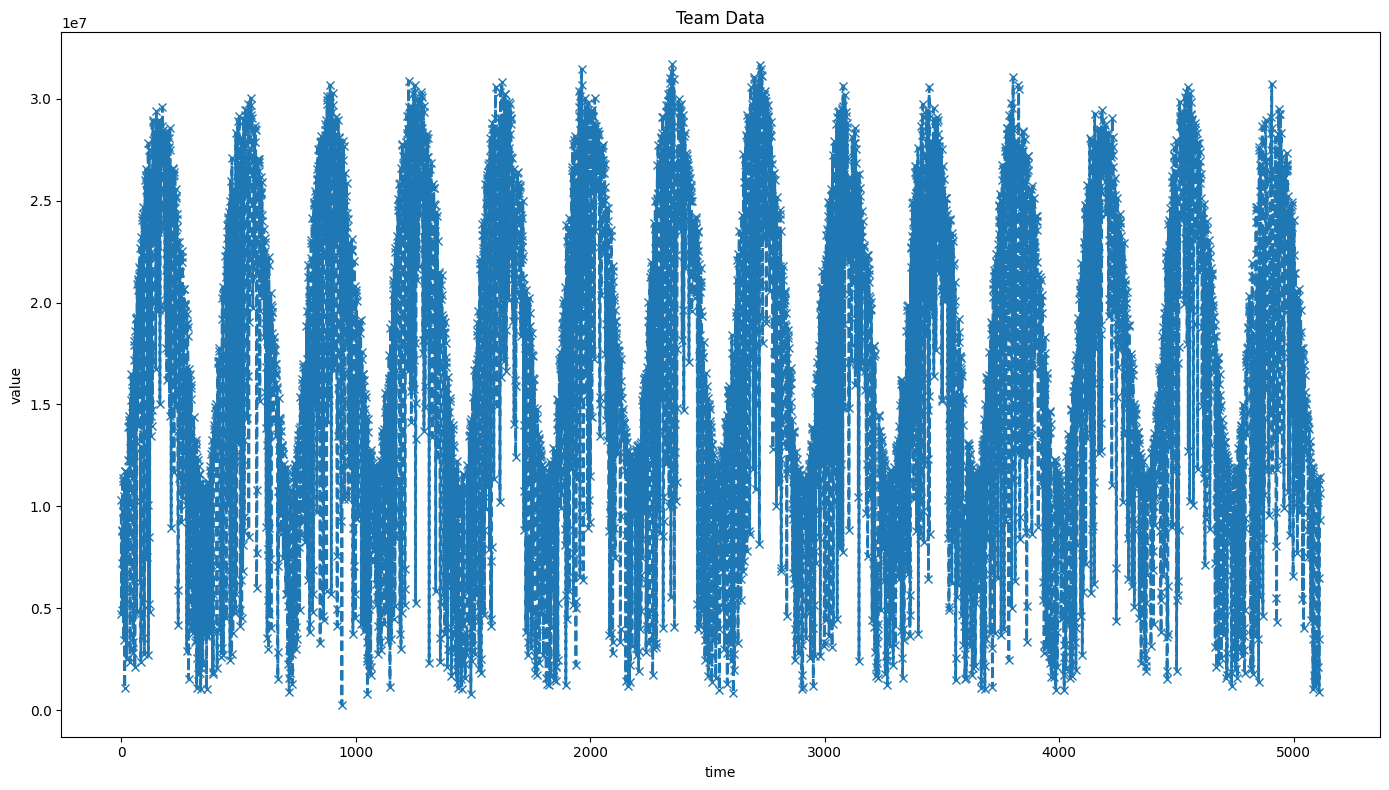

In [6]:
plot_timeseries(A,title='Team Data')

# Question 1

- Assume that A has no trend
- Remove Seasonality (can assume that s = 365)

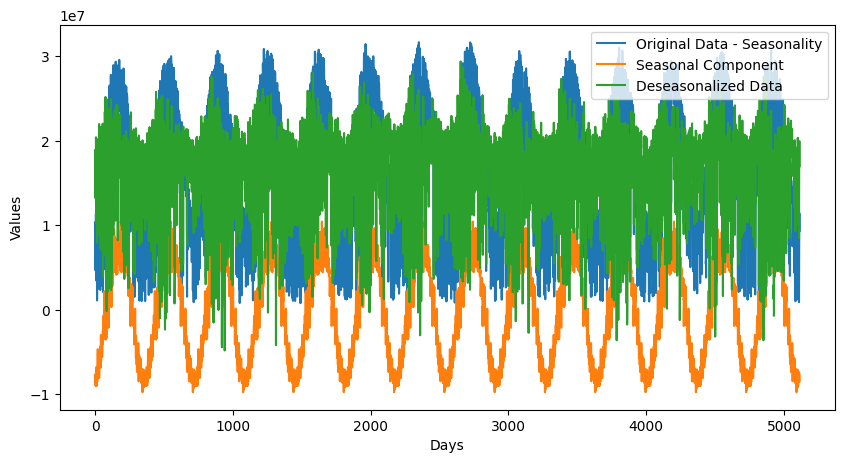

In [7]:
T_season = 365
s = seasonal_components(A, T_season)
A_static= A - s
plt.figure(figsize=(10,5))
plt.plot(A,label='Original Data - Seasonality')
plt.plot(s,label="Seasonal Component")
plt.plot(A_static,label='Deseasonalized Data')
plt.legend()
plt.xlabel("Days")
plt.ylabel("Values")
plt.show()



# Question 2

- Investigate if the `A_static` is White Noise (WN).
- A time series is considered White Noise (WN) if it satisfies the following conditions:

  1. **Mean**:
     $$
     E[X_t] = 0, \quad \text{for each } t.
     $$

  2. **Variance**:
     $$
     \text{Var}[X_t] = \sigma^2, \quad \text{constant for each } t.
     $$

  3. **Covariance**:
     $$
     \text{Cov}(X_t, X_{t+k}) = 0, \quad \text{the observations are independent from one another.}
     $$


- So i will plot the autocorrelation figure and i will check if the autocorrelation is within the confidence interval. More specifically i will check if the autocorrelation is within the confidence interval for all tau expect tau = 0
- Another way to check the above is to use the portmanteau test

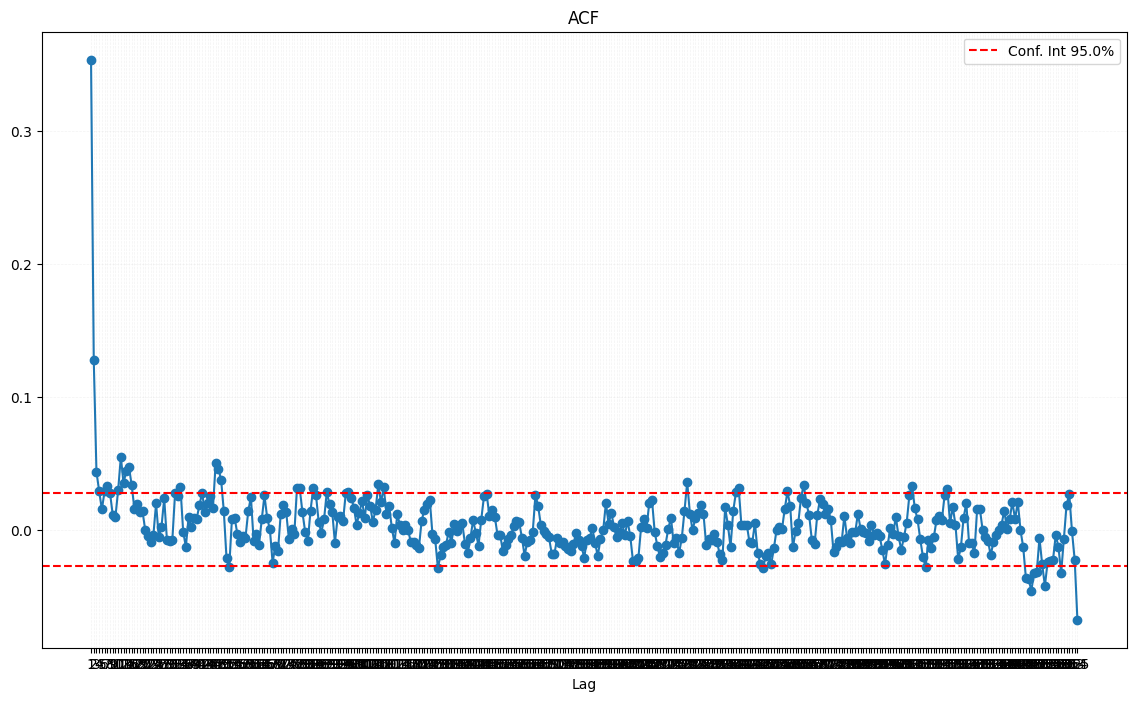

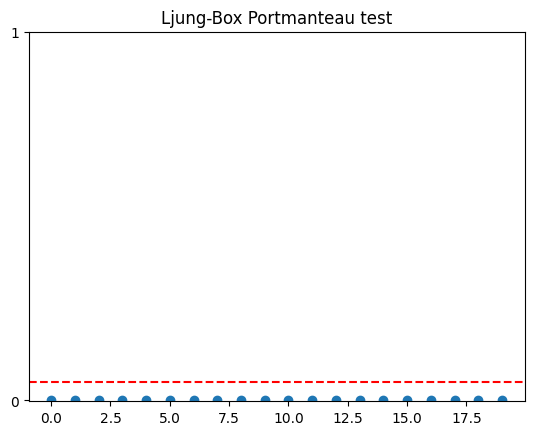

Reject the null hypothesis that the time series is independently distributed.


In [8]:
# # Check the mean
# print(f"Mean of the A_Static timeseries: {np.mean(A_static):.2f}")

# # Check the variance
# print(f"Variance of the A_Static timeseries: {np.var(A_static):.2f}")

# Check the autocorrelation
acfV = get_acf(A_static, lags=365, alpha=0.05, show=True)

#Check the portmanteau test
ljung_val, ljung_pval = portmanteau_test(A_static, maxtau=20, show=True)

if np.any(ljung_pval < 0.05):
    print(f"Reject the null hypothesis that the time series is independently distributed.")
else:
    print(f"Accept the null hypothesis that the time series is independently distributed.")

# Question 3

- Find the best linear model for `A_static`.
- To be this model appropriate, its residuals should be WN

In [9]:
best_linear_model = arimamodel(A_static) #no trend in the data
print(best_linear_model.summary())


 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=172883.189, Time=0.06 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_

 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=172293.232, Time=0.18 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=172219.518, Time=0.28 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=172215.076, Time=0.33 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=172212.250, Time=0.43 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=172213.755, Time=0.46 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=172203.276, Time=0.14 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=172205.252, Time=0.25 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=172207.233, Time=0.36 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=172208.664, Time=0.47 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=172209.922, Time=0.62 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=172205.219, Time=0.16 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=172207.220, Time=0.43 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=172209.188, Time=0.81 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=172209.160, Time=1.60 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(0,0,0)[1] intercept   : AIC=172207.169, Time=0.22 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(0,0,0)[1] intercept   : AIC=172209.170, Time=0.70 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(0,0,0)[1] intercept   : AIC=172210.999, Time=0.67 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,0)(0,0,0)[1] intercept   : AIC=172207.835, Time=0.25 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,1)(0,0,0)[1] intercept   : AIC=172209.835, Time=0.86 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,0)(0,0,0)[1] intercept   : AIC=172209.835, Time=0.32 sec

Best model:  ARIMA(1,0,0)(0,0,0)[1] intercept
Total fit time: 9.621 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 5113
Model:               SARIMAX(1, 0, 0)   Log Likelihood              -86098.638
Date:                Thu, 20 Feb 2025   AIC                         172203.276
Time:                        22:32:55   BIC                         172222.894
Sample:                             0   HQIC                        172210.144
                               - 5113                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.077e+07   2.37e-10   4.54e+16      0.000    1.08e+0

## Verify the findings using the ACF and PACF

Using the `arimamodel` i found that the best model is ARIMA(1,0,0) = AR(1)

From the figures below i can say that the AR(1) model is appropriate because the PACF is significant only for tau = 1. 

Also because a = 0.05 i can allow 1 error in 20, so i can allow that for tau = 12, the partial autocorrelation is not considered to be 0.

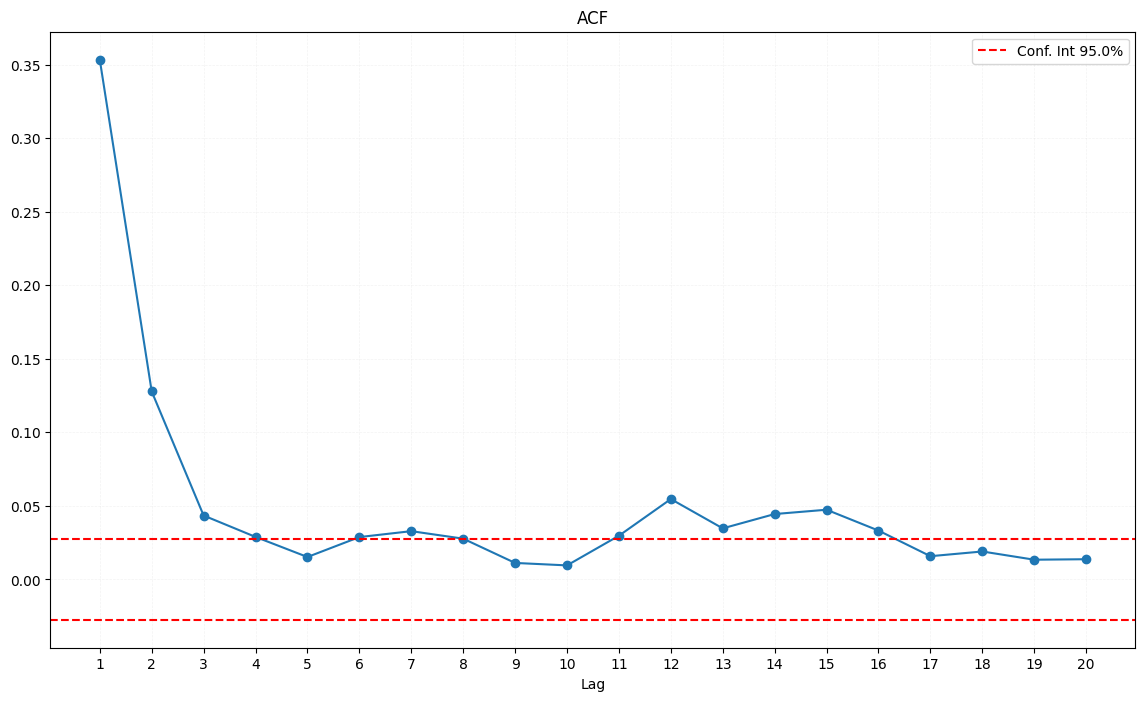

In [10]:
acfV = get_acf(A_static, lags=20, alpha=0.05, show=True)


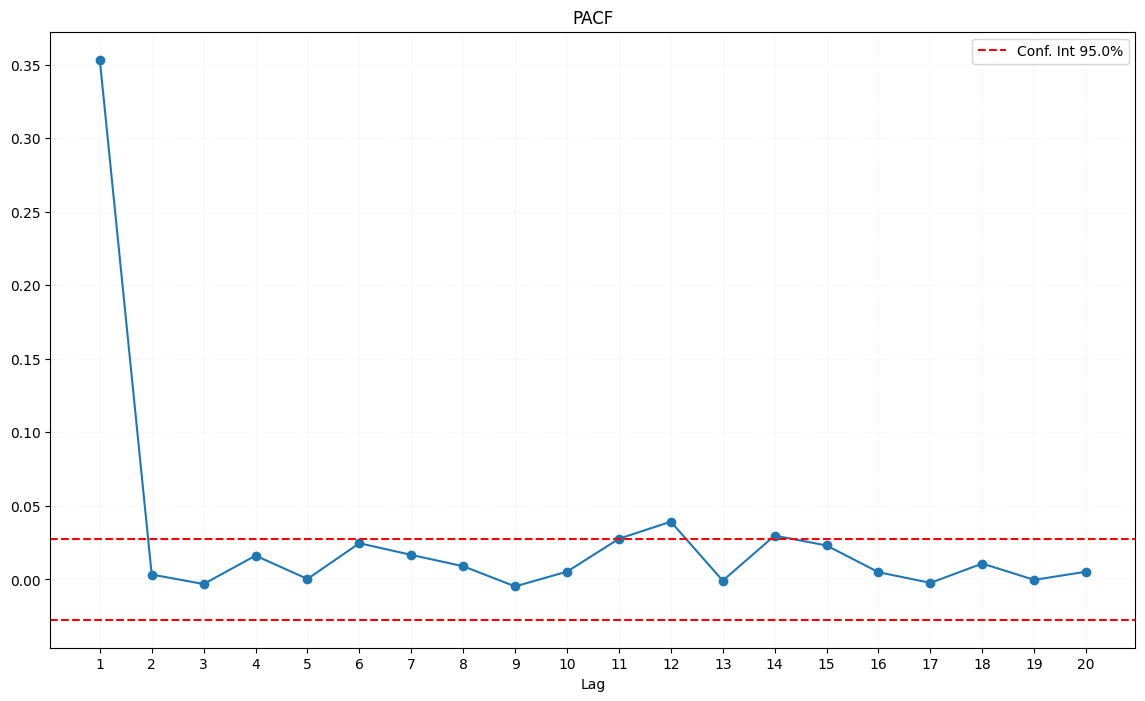

In [11]:
pacfV = get_pacf(A_static, lags=20, alpha=0.05, show=True)

## Chack goodness of fitted model

- plots a histogram of residuals (resid), which should ideally be normally distributed.
- If residuals are uncorrelated (white noise), the model fits well.

In [12]:
best_p = best_linear_model.order[0]
best_q = best_linear_model.order[2]
best_d = best_linear_model.order[1]
summary, fittedvalues, resid, model, aic = fit_arima_model(xV=A_static, p=best_p, q=best_q, d=best_d, show=False)

Mean of the residuals: 23.83
Variance of the residuals: 24764360836694.09


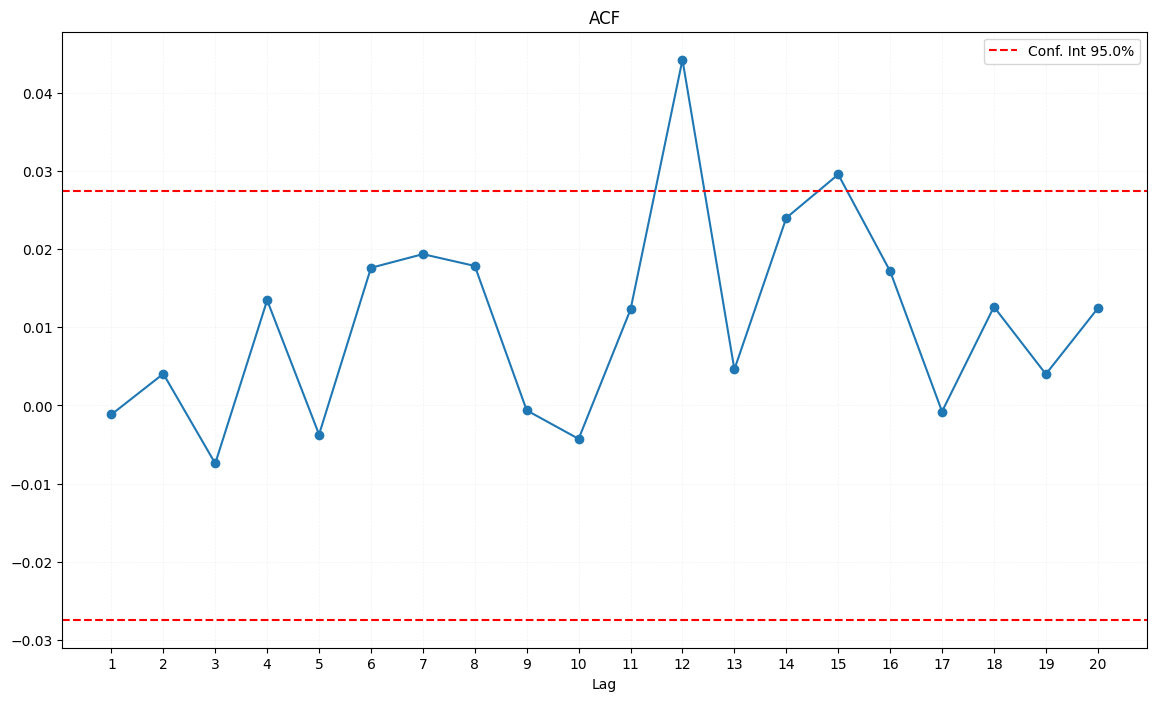

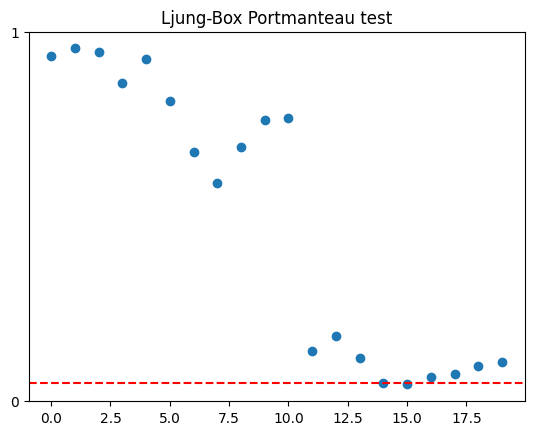

Reject the null hypothesis that the time series is independently distributed.


In [13]:
# Check if the residuals are white noise
print(f"Mean of the residuals: {np.mean(resid):.2f}")   
print(f"Variance of the residuals: {np.var(resid):.2f}")
acfV = get_acf(resid, lags=20, alpha=0.05, show=True)

#Check the portmanteau test
ljung_val, ljung_pval = portmanteau_test(resid, maxtau=20, show=True)
if np.any(ljung_pval < 0.05):
    print(f"Reject the null hypothesis that the time series is independently distributed.")
else:
    print(f"Accept the null hypothesis that the time series is independently distributed.")

# Question 4

In [14]:
# the data are from 1/1/1994 to 31/12/2007
# i will use the data from 1/1/1994 to 31/12/2006 to train the model
# and the data from 1/1/2007 to 31/12/2007 to test the model

data_df['Date'] = pd.to_datetime(data_df['Date'], format='%Y%m%d')  
data_df.set_index('Date', inplace=True)

split = data_df.loc['1994-01-01':'2006-12-31'].shape[0]
print(f"Number of days in the training data: {split}")


Number of days in the training data: 4748


In [15]:

A_static_train = A_static[:split]
A_static_test = A_static[split:]
s_test = s[split:]
s_train = s[:split]


In [16]:

#Find the best ARIMA model for the training data
train_model = arimamodel(A_static_train) #no trend in the data


 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=160487.608, Time=0.05 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_

 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=159964.357, Time=0.16 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=159899.578, Time=0.25 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=159897.231, Time=0.30 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=159896.770, Time=0.37 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=159898.178, Time=0.41 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=159889.003, Time=0.10 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=159891.017, Time=0.23 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=159892.903, Time=0.33 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=159893.880, Time=0.45 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=159895.730, Time=0.61 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=159891.001, Time=0.14 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=159893.001, Time=0.40 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=159894.345, Time=0.71 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=159895.554, Time=1.07 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(0,0,0)[1] intercept   : AIC=159892.289, Time=0.23 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(0,0,0)[1] intercept   : AIC=159894.289, Time=0.79 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(0,0,0)[1] intercept   : AIC=159896.114, Time=0.72 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,0)(0,0,0)[1] intercept   : AIC=159893.674, Time=0.23 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,1)(0,0,0)[1] intercept   : AIC=159895.674, Time=0.85 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,0)(0,0,0)[1] intercept   : AIC=159895.672, Time=0.31 sec

Best model:  ARIMA(1,0,0)(0,0,0)[1] intercept
Total fit time: 8.736 seconds


In [17]:

#Fit the best ARIMA model to the training data
best_p = train_model.order[0]
best_q = train_model.order[2]
best_d = train_model.order[1]
summary, fittedvalues, resid, model, aic = fit_arima_model(xV=A_static_train, p=best_p, q=best_q, d=best_d, show=False)






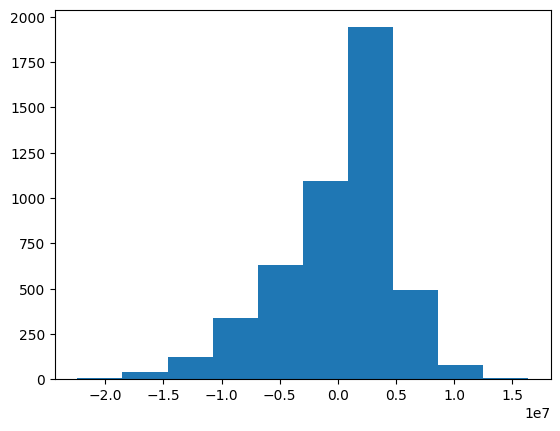

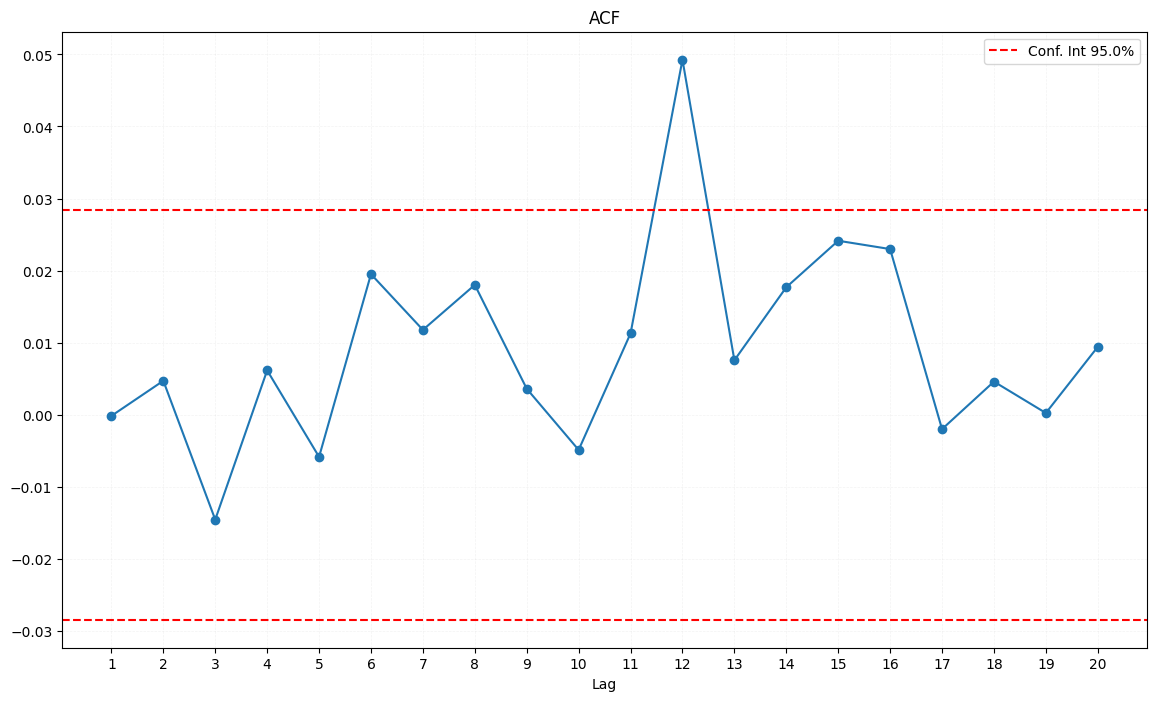

In [18]:
# Check goodness of fitted model
# Check if the residuals are white noise
# and if the residuals are normally distributed
plt.figure()
plt.hist(resid)
acfV = get_acf(resid, lags=20, alpha=0.05, show=True)

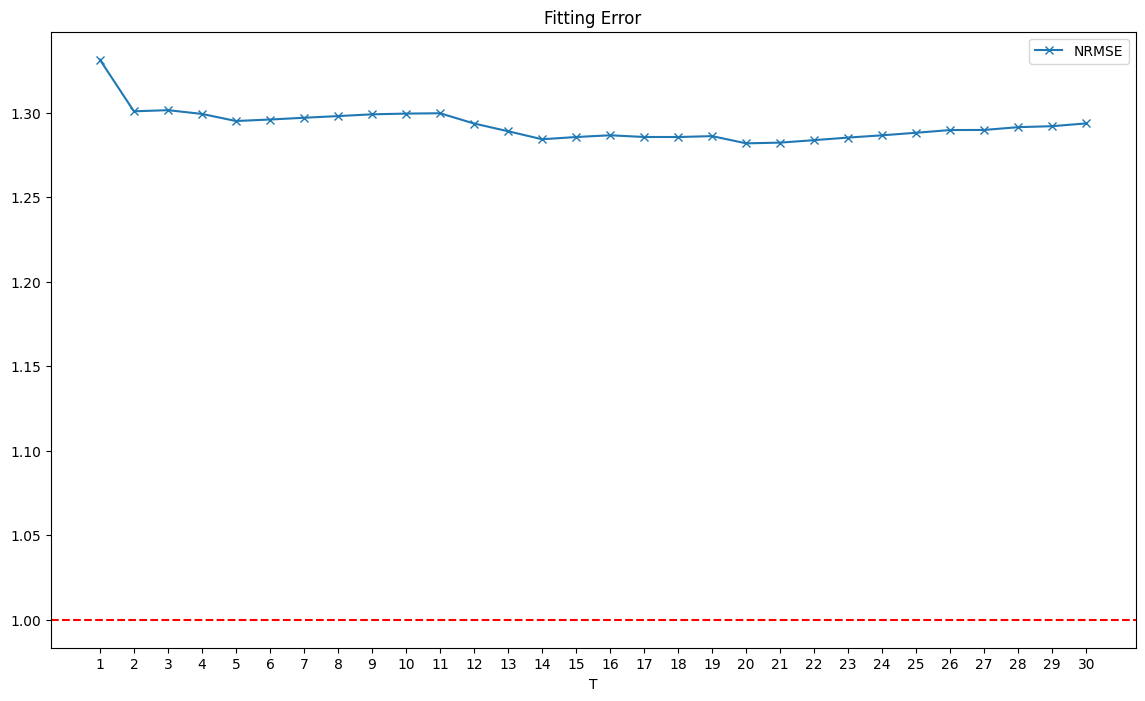

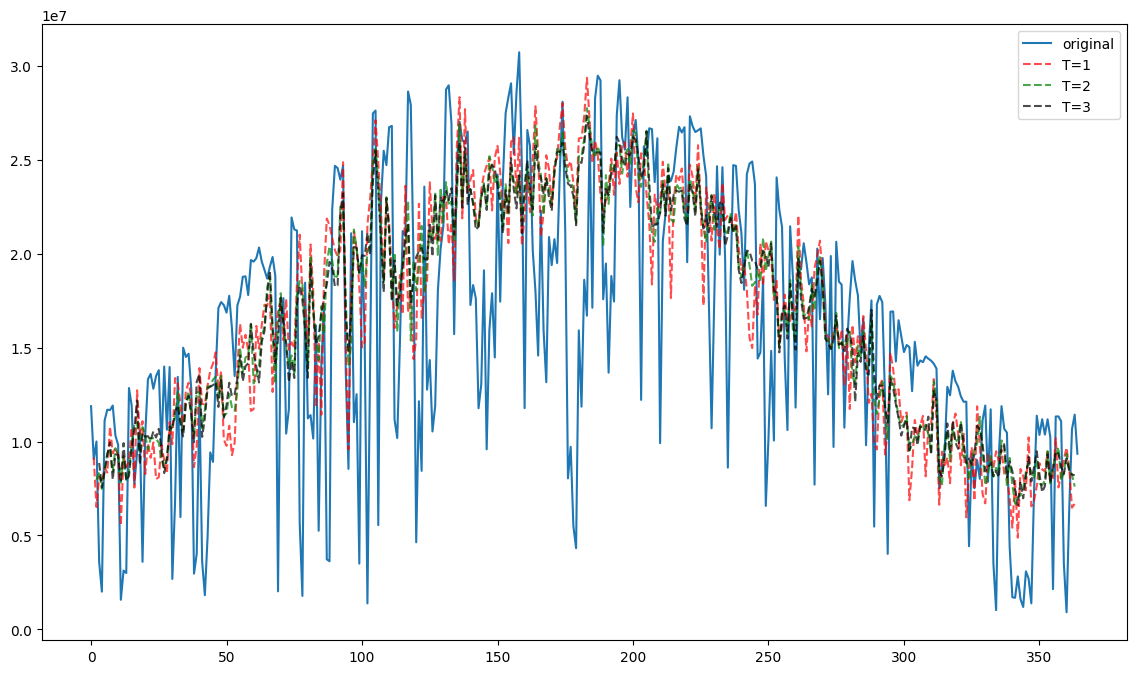

In [19]:
# get fit error
nrmseV, predM = calculate_fitting_error(A_static_test, model, Tmax=31, show=True,original=True,s=s_test)


# Question 5

## First try using seasonality

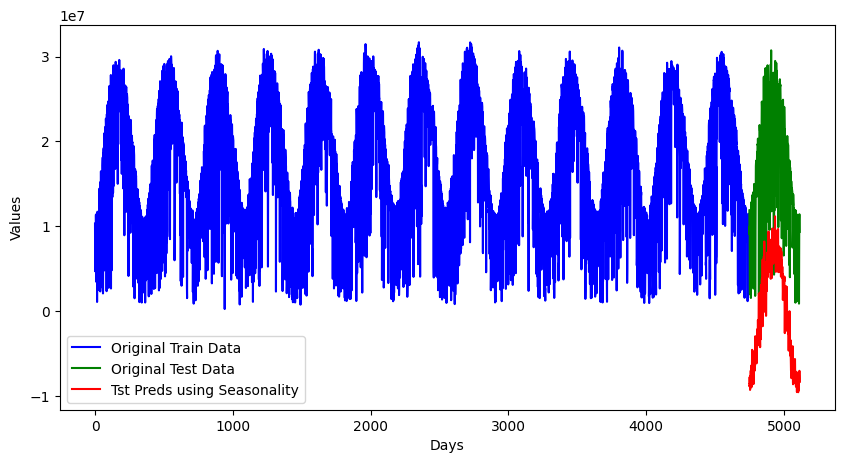

In [27]:
T_season = 365
A_train = A[:split]
A_test = A[split:]
s_train = seasonal_components(A_train, T_season) 

preds = s_train[:T_season] 
plt.figure(figsize=(10,5))
plt.plot(range(split), A_train, label='Original Train Data', color='blue')
plt.plot(range(split, split+T_season), A_test, label='Original Test Data', color='green')
plt.plot(range(split, split+T_season), preds, label='Tst Preds using Seasonality', color='red')
plt.legend()
plt.xlabel("Days")
plt.ylabel("Values")
plt.show()



## Second try using the mean of each day of the year with T=365

## Second try using the mean of each day of the year with T=365

In [ ]:
preds = np.full(shape=(T_season,), fill_value=np.nan)

for i in range(T_season):
    preds[i] = A_train[i:T_season:].mean()

In [36]:
px = np.arange(1,100)
px

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])